<a href="https://colab.research.google.com/github/project-mlx/mlx-case-studies/blob/main/price_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Retail Price Optimization:** of Olist Products (dataset available on Kaggle)

Below are the operations (and their progress in this notebook) we are going to perform for the optimization.
- Sales Data Collection-----------------------------------------*DONE*
- Products Selection For The Optimization----------*DONE*
- EDA--------------------------------------------------------------------*WIP*
- Feature Selection-----------------------------------------------*NA*
- Data Modelling & Forecast--------------------------------*NA*
- Optimization------------------------------------------------------*NA*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Reading  orders and order-items datasets from Olist
order_df = pd.read_csv('/content/drive/MyDrive/Datasets/OlistDataset/olist_orders_dataset.csv')
order_items_df = pd.read_csv('/content/drive/MyDrive/Datasets/OlistDataset/olist_order_items_dataset.csv')

**Working on the Order dataset**

In [ ]:
order_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
#Taking only required column for further EDA
order_df_filt = order_df[['order_id','order_purchase_timestamp']]

In [ ]:
order_df_filt.isna().sum()

order_id                    0
order_purchase_timestamp    0
dtype: int64

In [ ]:
order_df_filt.shape

(99441, 2)

In [ ]:
#Converting the datetime column to pandas Date
order_df_filt.order_purchase_timestamp = pd.to_datetime(order_df_filt.order_purchase_timestamp)
order_df_filt['Date'] = order_df_filt.order_purchase_timestamp.dt.date

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Working on the Order Items dataset**

In [ ]:
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [ ]:
#Joining the Order and Order Items datasets using Order ID
sales_df = order_df_filt.join(order_items_df.set_index('order_id'), on='order_id')

In [ ]:
#Taking only required fields which will be useful for the analysis and forecast
sales_df = sales_df[['Date','product_id','seller_id','price']]

**Preparing the sales dataset for further analysis**

In [ ]:
#Grouping the data and counting the sales unit product-wise
analysis_DF = sales_df.groupby(['Date','product_id','seller_id','price']
                               ).size().reset_index(name='sales_unit')
analysis_DF.shape

(94697, 5)

In [ ]:
analysis_DF

,Date,product_id,seller_id,price,sales_unit
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,39.99,1
1,2016-09-04,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,32.90,1
2,2016-09-05,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,59.50,1
3,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,3
4,2016-10-02,d2998d7ced12f83f9b832f33cf6507b6,25e6ffe976bd75618accfe16cefcbd0d,100.00,1
...,...,...,...,...,...
94692,2018-08-29,b6b76b074ed0d77d0f3443b12d8adb5e,6560211a19b47992c3666cc44a7e94c0,99.00,1
94693,2018-08-29,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,45.90,1
94694,2018-08-29,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,24.90,1
94695,2018-08-29,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,84.99,1


Now the dataset is ready for analysis

We will now filter the dataset and decide which products to keep and which to drop. We need the items that have enough sales, consistent demand variablility, and the number of price changes in a certain time period to be considered for a forecast and optimization.

- the product which has been most consistently sold at least once over the intervals of 10 weeks.
- 

In [ ]:
#Converting DF date column to Datetime
analysis_DF.Date = pd.to_datetime(analysis_DF.Date)

In [ ]:
#Grouping product sales in the intervals of 10 weeks time period
grouped_product_sales = analysis_DF[['Date','product_id','sales_unit']].groupby(
    [pd.Grouper(key="Date", freq="10W"), analysis_DF.product_id]).sum().reset_index()

In [ ]:
#Getting the top products which sales has occurred in the significant number 
#(>= 5 intervals) of the time intervals.
#In laymen terms, the product which has been most consistently sold at least
#once within 10 weeks.
top_products = grouped_product_sales.product_id.value_counts()
top_products = top_products[top_products>=5]
top_products

777d2e438a1b645f3aec9bd57e92672c    10
817e1c2d22418c36386406ccacfa53e8    10
6cdd53843498f92890544667809f1595    10
11fd9d7ba552e1d28872e008acf1e050     9
35afc973633aaeb6b877ff57b2793310     9
                                    ..
e2fcaac49de7a3a90f0dc74d7b1e9f10     5
cd48f265a63e13b762601f5f794c5fca     5
1d2d3b19f5c3d093d4dbccd3cd963a8f     5
84f5c4f480ad6c9998d6a6860f1a2e41     5
4ebab6a2135a2477b657bda38646b64b     5
Name: product_id, Length: 1166, dtype: int64

In [ ]:
"""pivot_date_item = grouped_product_sales.pivot_table(index='product_id',columns='Date', 
                                      values='sales_unit').dropna().index
pivot_date_item
"""                

"pivot_date_item = grouped_product_sales.pivot_table(index='product_id',columns='Date', \n                                      values='sales_unit').dropna().index\npivot_date_item\n"

In [ ]:
analysis_DF = analysis_DF[analysis_DF.product_id.isin(top_products.index)]

In [ ]:
analysis_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25539 entries, 0 to 94695
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        25539 non-null  datetime64[ns]
 1   product_id  25539 non-null  object        
 2   seller_id   25539 non-null  object        
 3   price       25539 non-null  float64       
 4   sales_unit  25539 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
analysis_DF

,Date,product_id,seller_id,price,sales_unit
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,39.99,1
7,2016-10-03,9c7bdf67b06b419aefb93cfdfc96c55d,ed49da7cadefc454d6a67de249eab240,21.50,1
32,2016-10-04,473795a355d29305c3ea6b156833adf5,620c87c171fb2a6dd6e8bb4dec959fc6,59.90,2
43,2016-10-04,817e1c2d22418c36386406ccacfa53e8,624f4ece8da4aafb77699233d480f8ef,189.00,1
55,2016-10-04,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,39.99,1
...,...,...,...,...,...
94674,2018-08-28,a59fb60fddcc72a9878b7ed5cb69d8e4,7040e82f899a04d1b434b795a43b4617,14.90,1
94680,2018-08-28,d6aa421b9567e3e2a3a0caf8fb846cbc,99a54764c341d5dc80b4a8fac4eba3fb,41.80,1
94682,2018-08-28,e06f99e79036d681effa3de75989bf22,6560211a19b47992c3666cc44a7e94c0,59.00,1
94683,2018-08-28,e0cf79767c5b016251fe139915c59a26,da8622b14eb17ae2831f4ac5b9dab84a,29.90,1


The dataset is down to around 1000 products.

We will filter the dataset even further by grouping the products based on the demand variability (smooth, intermittent, erratic, and lumpy).

please refer https://frepple.com/blog/demand-classification/


**Classifying the products on daily sales**

In [ ]:
#ADI (Total no of periods/number of demand bucket) function
def ADI(no_demand_buckets, no_of_periods):
  ADI = no_of_periods/no_demand_buckets
  return ADI

In [ ]:
#Calculating number of sales occurence (demand buckets) of each product on different time periods
top_products_daily = analysis_DF.product_id.value_counts()

In [ ]:
top_products_daily

99a4788cb24856965c36a24e339b6058    269
d1c427060a0f73f6b889a5c7c61f2ac4    202
422879e10f46682990de24d770e7f83d    196
2b4609f8948be18874494203496bc318    193
154e7e31ebfa092203795c972e5804a6    192
                                   ... 
125e5760a3ff01937be3b2a1a7f14aa6      5
783dae38feb9e3a364e24e25168cfa8a      5
d3f4f3de0f4576184674937d1e9cecca      5
190d9562bfbe9d3ed876c2ac6f2f5894      5
72ca7a219f9f5b1be88c79e3aedd0152      5
Name: product_id, Length: 1166, dtype: int64

In [ ]:
#Calculating ADI of each product
top_product = top_products_daily.reset_index()
top_product.columns = ['product_id','demand_bucket']
no_of_periods = len(analysis_DF.Date.unique())
top_product['ADI'] = top_product.demand_bucket.apply(ADI, args=[no_of_periods])

In [ ]:
#Calculating Standard Deviation and Mean of each product's sales occurence on different time periods
sub_analyse_std = analysis_DF[['product_id','sales_unit']].groupby(
    ['product_id']).std().reset_index()
sub_analyse_mean = analysis_DF[['product_id','sales_unit']].groupby(
    ['product_id']).mean().reset_index()

In [ ]:
sub_analyse = sub_analyse_std.join(sub_analyse_mean.set_index('product_id'),
                                   lsuffix='_std', rsuffix='_mean',
                                   on='product_id')

sub_analyse = sub_analyse.join(top_product.set_index('product_id'),
                                   on='product_id')

In [ ]:
#Calculating CV2 (Sales units Standard Dev/mean)^2
sub_analyse['CV2'] = (sub_analyse.sales_unit_std/sub_analyse.sales_unit_mean)**2

Smooth demand (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level.

Intermittent demand (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.

Erratic demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.

Lumpy demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.

In [ ]:
conditions = [
    (sub_analyse.ADI < 1.32) & (sub_analyse.CV2 < 0.49),
    (sub_analyse.ADI >= 1.32) & (sub_analyse.CV2 < 0.49),
    (sub_analyse.ADI < 1.32) & (sub_analyse.CV2 >= 0.49),
    (sub_analyse.ADI >= 1.32) & (sub_analyse.CV2 >= 0.49)
    ]
profiles = ['smooth', 'intermittent', 'erratic', 'lumpy']

In [ ]:
#Creating a new column of demand profile and assigning them to products,
#based on the conditions defined above.
sub_analyse['demand_profile'] = np.select(conditions, profiles)

In [ ]:
sub_analyse

,product_id,sales_unit_std,sales_unit_mean,demand_bucket,ADI,CV2,demand_profile
0,002159fe700ed3521f46cfcf6e941c76,0.000000,1.000000,8,76.125000,0.000000,intermittent
1,00250175f79f584c14ab5cecd80553cd,1.511858,1.571429,7,87.000000,0.925620,lumpy
2,005030ef108f58b46b78116f754d8d38,0.288675,1.083333,12,50.750000,0.071006,intermittent
3,008cff0e5792219fae03e570f980b330,0.374634,1.157895,19,32.052632,0.104683,intermittent
4,00ba6d766f0b1d7b78a5ce3e1e033263,0.687552,1.454545,11,55.363636,0.223437,intermittent
...,...,...,...,...,...,...,...
1161,fed5c40c27e1c88560a9e92d82ee0825,0.307794,1.100000,20,30.450000,0.078295,intermittent
1162,ff29d8cb1cd0cd5ea37b80dac9939e1c,0.358569,1.142857,21,29.000000,0.098437,intermittent
1163,ff55834c0b3272853dfe62340f2bb91b,0.000000,1.000000,9,67.666667,0.000000,intermittent
1164,ff7fccf8513f360157f0660fe51d1d88,0.000000,1.000000,13,46.846154,0.000000,intermittent


**Classifying the products based on weekly sales**

In [ ]:
#Grouping the dataset weekly
weekly_subset = analysis_DF.groupby([analysis_DF.Date.dt.isocalendar().week,
                                     analysis_DF.product_id]).sum().reset_index()[['week','product_id','sales_unit']]

In [ ]:
#Calculating demand occurence of each product in all the periods
top_products_weekly = weekly_subset.product_id.value_counts()

In [ ]:
#Calculating ADI for weekly data
top_product_w = top_products_weekly.reset_index()
top_product_w.columns = ['product_id','demand_bucket_weekly']
no_of_periods = len(weekly_subset.week.unique())
top_product_w['ADI_weekly'] = top_product_w.demand_bucket_weekly.apply(ADI, args=[no_of_periods])

In [ ]:
#Calculating std and mean of sales unit for weekly data
weekly_subset_std = weekly_subset[['product_id','sales_unit']].groupby(
    ['product_id']).std().reset_index()
weekly_subset_mean = weekly_subset[['product_id','sales_unit']].groupby(
    ['product_id']).mean().reset_index()

In [ ]:
weekly_subset_std_mean = weekly_subset_std.join(weekly_subset_mean.set_index('product_id'),
                                   lsuffix='_week_std', rsuffix='_week_mean',
                                   on='product_id')

weekly = weekly_subset_std_mean.join(top_product_w.set_index('product_id'),
                                   on='product_id')

In [ ]:
sub_analyse = sub_analyse.join(weekly.set_index('product_id'),
                                   on='product_id')

In [ ]:
#Calculating CV2 for the weekly data
sub_analyse['CV2_week'] = (sub_analyse.sales_unit_week_std/
                           sub_analyse.sales_unit_week_mean)**2

In [ ]:
conditions = [
    (sub_analyse.ADI_weekly < 1.32) & (sub_analyse.CV2_week < 0.49),
    (sub_analyse.ADI_weekly >= 1.32) & (sub_analyse.CV2_week < 0.49),
    (sub_analyse.ADI_weekly < 1.32) & (sub_analyse.CV2_week >= 0.49),
    (sub_analyse.ADI_weekly >= 1.32) & (sub_analyse.CV2_week >= 0.49)
    ]
profiles = ['smooth', 'intermittent', 'erratic', 'lumpy']

In [ ]:
#Creating a new column of demand profile for weeky data and assigning them to products,
#based on the conditions defined above.
sub_analyse['weekly_demand_profile'] = np.select(conditions, profiles)

In [ ]:
sub_analyse

,product_id,sales_unit_std,sales_unit_mean,demand_bucket,ADI,CV2,demand_profile,sales_unit_week_std,sales_unit_week_mean,demand_bucket_weekly,ADI_weekly,CV2_week,weekly_demand_profile
0,002159fe700ed3521f46cfcf6e941c76,0.000000,1.000000,8,76.125000,0.000000,intermittent,0.377964,1.142857,7,7.428571,0.109375,intermittent
1,00250175f79f584c14ab5cecd80553cd,1.511858,1.571429,7,87.000000,0.925620,lumpy,2.041241,1.833333,6,8.666667,1.239669,lumpy
2,005030ef108f58b46b78116f754d8d38,0.288675,1.083333,12,50.750000,0.071006,intermittent,0.674949,1.300000,10,5.200000,0.269560,intermittent
3,008cff0e5792219fae03e570f980b330,0.374634,1.157895,19,32.052632,0.104683,intermittent,0.619139,1.375000,16,3.250000,0.202755,intermittent
4,00ba6d766f0b1d7b78a5ce3e1e033263,0.687552,1.454545,11,55.363636,0.223437,intermittent,0.699206,1.600000,10,5.200000,0.190972,intermittent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,fed5c40c27e1c88560a9e92d82ee0825,0.307794,1.100000,20,30.450000,0.078295,intermittent,0.915475,1.466667,15,3.466667,0.389610,intermittent
1162,ff29d8cb1cd0cd5ea37b80dac9939e1c,0.358569,1.142857,21,29.000000,0.098437,intermittent,1.382783,1.714286,14,3.714286,0.650641,lumpy
1163,ff55834c0b3272853dfe62340f2bb91b,0.000000,1.000000,9,67.666667,0.000000,intermittent,0.353553,1.125000,8,6.500000,0.098765,intermittent
1164,ff7fccf8513f360157f0660fe51d1d88,0.000000,1.000000,13,46.846154,0.000000,intermittent,0.404520,1.181818,11,4.727273,0.117160,intermittent


In [ ]:
daily_profile = sub_analyse[['demand_profile','product_id']].groupby(
    'demand_profile').size().reset_index(name='d_no_products')
    
weekly_profile = sub_analyse[['weekly_demand_profile','product_id']].groupby(
    'weekly_demand_profile').size().reset_index(name='w_no_products')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('seaborn')
%matplotlib inline

In [ ]:
def plot(x, y):
  plt.figure(figsize=(16, 9))
  plt.scatter(x, y, c='red', alpha=0.5)
  plt.axhline(y=1.32)
  plt.axvline(x=0.49)
  plt.title('Demand Variability of The Products On The Daily Data', size=30)
  plt.xlabel('CV2', size=30)
  plt.ylabel('ADI', size=30)
  plt.xticks(size=30)
  plt.yticks(size=30)
  plt.show()

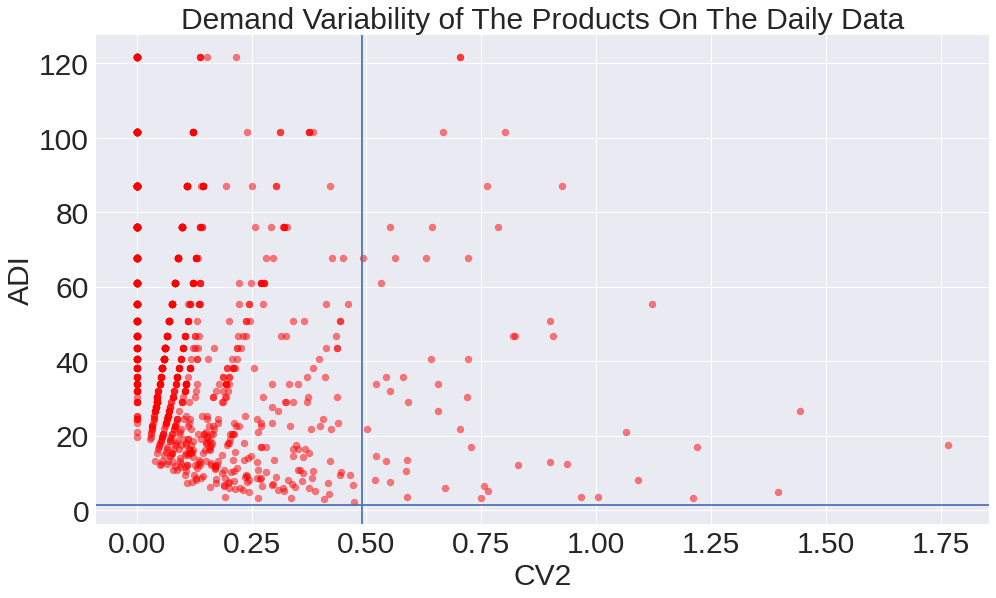

In [ ]:
#Demand Variability of The Products On The Daily Data
plot(sub_analyse.CV2, sub_analyse.ADI)

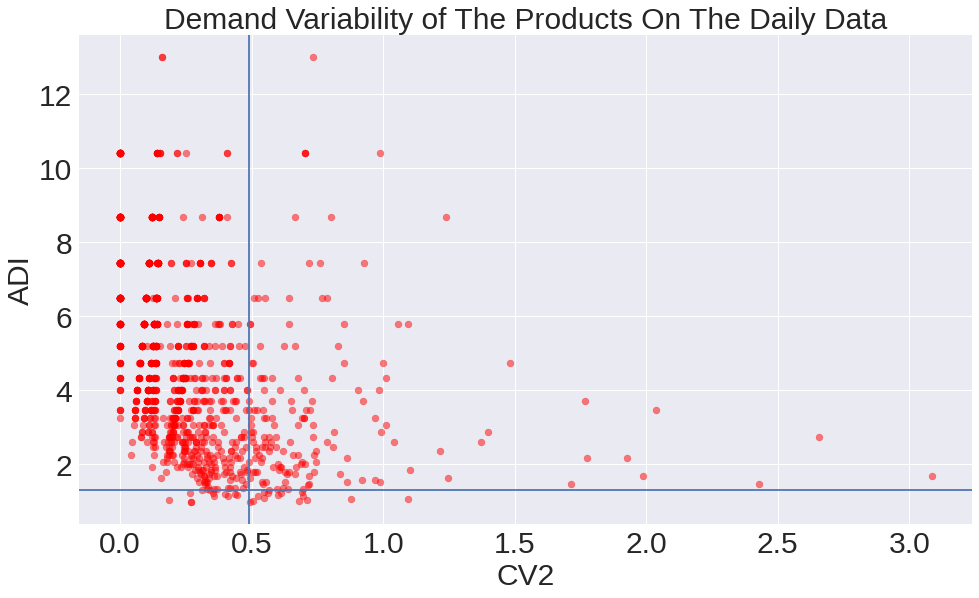

In [ ]:
#Demand Variability of The Products On The Weekly Data
plot(sub_analyse.CV2_week, sub_analyse.ADI_weekly)

In [ ]:
demand_v_ds = pd.merge(weekly_profile, daily_profile, how='left', 
                    left_on='weekly_demand_profile',
                    right_on='demand_profile').drop(columns=['demand_profile'])

demand_v_ds.columns = ['demand_profile','no_of_products_weekly','no_of_products_daily']
demand_v_ds

,demand_profile,no_of_products_weekly,no_of_products_daily
0,erratic,15,NaN
1,intermittent,986,1111.0
2,lumpy,153,55.0
3,smooth,12,NaN


As you can see, there is not Erratic or Smooth sales of the products on the daily sales data. Therefore, we are going to consider the weekly demand profile and filter the products. We will take the weekly aggregated data and we will select those products that fall in the smooth, erratic, and intermittent categories.

In [ ]:
filtered_products = sub_analyse[sub_analyse.weekly_demand_profile 
                                != 'lumpy'].product_id

In [ ]:
analysis_DF = analysis_DF[analysis_DF.product_id.isin(filtered_products)]
analysis_DF

,Date,product_id,seller_id,price,sales_unit
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,39.99,1
7,2016-10-03,9c7bdf67b06b419aefb93cfdfc96c55d,ed49da7cadefc454d6a67de249eab240,21.50,1
43,2016-10-04,817e1c2d22418c36386406ccacfa53e8,624f4ece8da4aafb77699233d480f8ef,189.00,1
55,2016-10-04,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,39.99,1
67,2016-10-04,f422d0d9f8b5f7c27289382b14b61248,1554a68530182680ad5c8b042c3ab563,69.99,1
...,...,...,...,...,...
94627,2018-08-27,d2f5484cbffe4ca766301b21ab9246dd,36a968b544695394e4e9d7572688598f,12.88,1
94637,2018-08-27,e9c1abcc7126360336d8f56d49041a8c,679769a98cfcc6da877c8486ff1c13f3,349.00,1
94668,2018-08-28,719d571299707561c34ba04ab867b32a,0ef83d7d83ed97cd2a0049ac8be5f88a,49.00,1
94680,2018-08-28,d6aa421b9567e3e2a3a0caf8fb846cbc,99a54764c341d5dc80b4a8fac4eba3fb,41.80,1


- Selecting the products that have historically changed their price at least three times in the 2-year span

- Each of these prices has at least four days of sales.

In [ ]:
sub_df_2Y = analysis_DF[['product_id','price']
                        ].groupby([analysis_DF.product_id,
                                   analysis_DF.price]
                                  ).size().reset_index(name='sales_days')

sub_df_2Y = sub_df_2Y[sub_df_2Y.sales_days >= 4]

top_p_price_change = sub_df_2Y.product_id.value_counts()
top_p_price_change = top_p_price_change[top_p_price_change>=3].index

sub_df_2Y = sub_df_2Y[sub_df_2Y.product_id.isin(top_p_price_change)]

In [ ]:
filtered_products_cs = sub_df_2Y.product_id.unique()

In [ ]:
print('Number of Products: {}'.format(len(filtered_products_cs)))

Number of Products: 84


In [ ]:
analysis_DF = analysis_DF[analysis_DF.product_id.isin(filtered_products_cs)]
analysis_DF

,Date,product_id,seller_id,price,sales_unit
442,2017-01-16,ca38c039b717207dec906f4fa9a21db7,59fb871bf6f4522a87ba567b42dafecf,164.99,1
443,2017-01-16,ca38c039b717207dec906f4fa9a21db7,59fb871bf6f4522a87ba567b42dafecf,184.99,1
497,2017-01-18,a1bf559ac1eab015ba992bd76d9d76c7,85d9eb9ddc5d00ca9336a2219c97bb13,19.90,1
506,2017-01-18,d696750e550fd0f733979dd7e5dff921,9de4643a8dbde634fe55621059d92273,173.85,1
526,2017-01-19,91b08d34d0ba4db44da2dc382867ba49,b76dba6c951ab00dc4edf0a1aa88037e,6.90,1
...,...,...,...,...,...
94443,2018-08-25,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,49.90,1
94475,2018-08-25,c4baedd846ed09b85f78a781b522f126,a1043bafd471dff536d0c462352beb48,89.99,1
94500,2018-08-25,fbc1488c1a1e72ba175f53ab29a248e8,289cdb325fb7e7f891c38608bf9e0962,116.90,2
94579,2018-08-27,06bf70b6e1d67d96308235ef350edc61,2c9e548be18521d1c43cde1c582c6de8,79.90,1


Above is the dataset containing top products on which the forecast and price optimization can be performed.

Further analysis about disribution, anomaly/outlier detection, and out-of-stock soon will be uploaded here.

The forecsast and optimization will be performed after further analysis.